PART Ⅰ

总共有6年的数据（1960、1971、1980、1988、1993、2003），分别来源于不同的文献中

每项数据具有四个特征，分别为：气体组成、温度(K)、压力(MPa)、硫溶解度(mmol/mol)

由于化学物理的性质是自然界规律，不会受到时间的影响，并且假设硫溶解度主要受到气体组成、温度和压力的影响，忽略不同实验环境的影响

由于数据存储在excel中，且数据间单元格存在合并，需要将所有年份数据清洗整合

In [ ]:
import pandas as pd

# 假设每个年份的数据在不同的sheet中
excel_path = r'e:\New_Project(python)\数据挖掘\data\硫溶解度预测-数据集.xlsx'
all_years = ['1960', '1971', '1980', '1988', '1993', '2003']
df_list = []

for year in all_years:
    df = pd.read_excel(excel_path, sheet_name=year)
    # 填充合并单元格后的空值（向下填充）
    df = df.fillna(method='ffill')
    # 可选：去除全空行、全空列
    df = df.dropna(how='all').dropna(axis=1, how='all')
    # 可选：添加年份信息
    df['year'] = year
    df_list.append(df)

# 合并所有年份
all_data = pd.concat(df_list, ignore_index=True)

# 可选：统一列名
#all_data.columns = ['数据来源', '气体组成', '温度(K)', '压力(MPa)', '硫溶解度(mmol/mol)', '年份']

# 保存清洗后的数据
all_data.to_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data.xlsx', index=False)

# 显示前几行
print(all_data.head())

                                                数据来源     气体组成  温度（K）  压力（MPa）  \
0  Equilibrium in the Methane-Carbon Dioxide-Hydr...  100%CH4  338.7     6.89   
1  Equilibrium in the Methane-Carbon Dioxide-Hydr...  100%CH4  338.7    13.79   
2  Equilibrium in the Methane-Carbon Dioxide-Hydr...  100%CH4  338.7    20.68   
3  Equilibrium in the Methane-Carbon Dioxide-Hydr...  100%CH4  338.7    27.57   
4  Equilibrium in the Methane-Carbon Dioxide-Hydr...  100%CH4  338.7    34.47   

   硫溶解度(mmol/mol)  year  硫溶解度（mmol/mol）  
0           0.000  1960             NaN  
1           0.001  1960             NaN  
2           0.002  1960             NaN  
3           0.003  1960             NaN  
4           0.006  1960             NaN  


经过清洗的数据将被保存到 `cleaned_data.xlsx` 文件中，通过检查数据可以发现数据任然存在一下错误：

①温度的部分数据带有单位K

②硫溶解度数据被拆成了两列，没有很好的被融合

③气体成分部分有些以百分比计算，有些直接写 “纯”, 命名不统一

In [18]:
import pandas as pd
import re

# 读取已初步清洗的数据
df = pd.read_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data.xlsx')

# ① 温度的部分数据带有单位K，去掉单位并转为数值
def clean_temperature(val):
    if pd.isnull(val):
        return None
    # 提取数字
    match = re.search(r'(\d+\.?\d*)', str(val))
    return float(match.group(1)) if match else None

df['温度（K）'] = df['温度（K）'].apply(clean_temperature)

# ② 硫溶解度数据被拆成了两列，合并为一列
# 假设两列名为 '硫溶解度1' 和 '硫溶解度2'，实际请替换为你的真实列名
sulfur_cols = [col for col in df.columns if '硫溶解度' in col]
if len(sulfur_cols) > 1:
    # 合并两列，优先取非空值
    df['硫溶解度(mmol/mol)'] = df[sulfur_cols].bfill(axis=1).iloc[:, 0]
    # 删除原有多余的硫溶解度列
    for col in sulfur_cols:
        if col != '硫溶解度(mmol/mol)':
            df.drop(columns=col, inplace=True)

# ③ 将“纯”替换为“100%”，其余不变
df['气体组成'] = df['气体组成'].replace({'纯H2S': '100%H2S'})

# 保存最终清洗结果
df.to_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data_final.xlsx', index=False)
df.head()

,数据来源,气体组成,温度（K）,压力（MPa）,硫溶解度(mmol/mol),year
0,Equilibrium in the Methane-Carbon Dioxide-Hydr...,100%CH4,338.7,6.89,0.000,1960
1,Equilibrium in the Methane-Carbon Dioxide-Hydr...,100%CH4,338.7,13.79,0.001,1960
2,Equilibrium in the Methane-Carbon Dioxide-Hydr...,100%CH4,338.7,20.68,0.002,1960
3,Equilibrium in the Methane-Carbon Dioxide-Hydr...,100%CH4,338.7,27.57,0.003,1960
4,Equilibrium in the Methane-Carbon Dioxide-Hydr...,100%CH4,338.7,34.47,0.006,1960


PART Ⅱ

二次清洗完成后检查数据，总共获得540条数据，数据完好且没有缺失值

接下来考虑如何对气体组成成分进行合适编码以及采用什么方式进行学习

首先，绘制温度、压力对硫溶解度的三维图像，观察总体变化趋势

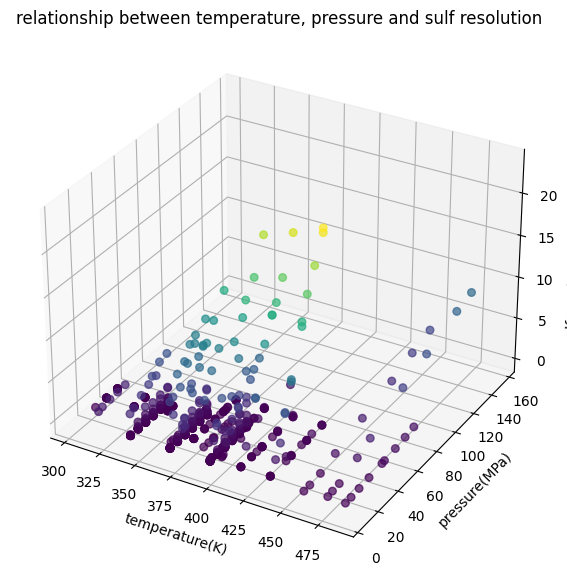

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 读取最终清洗后的数据
df = pd.read_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data_final.xlsx')

# 假设列名为：'温度（K）'、'压力(MPa)'、'硫溶解度(mmol/mol)'
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['温度（K）'], df['压力（MPa）'], df['硫溶解度(mmol/mol)'],
           c=df['硫溶解度(mmol/mol)'], cmap='viridis', s=30, alpha=0.7)

ax.set_xlabel('temperature(K)')
ax.set_ylabel('pressure(MPa)')
ax.set_zlabel('sulf resolution(mmol/mol)')
ax.set_title('relationship between temperature, pressure and sulf resolution')

plt.show()

进一步绘制二维图像观察单个因素的变化趋势

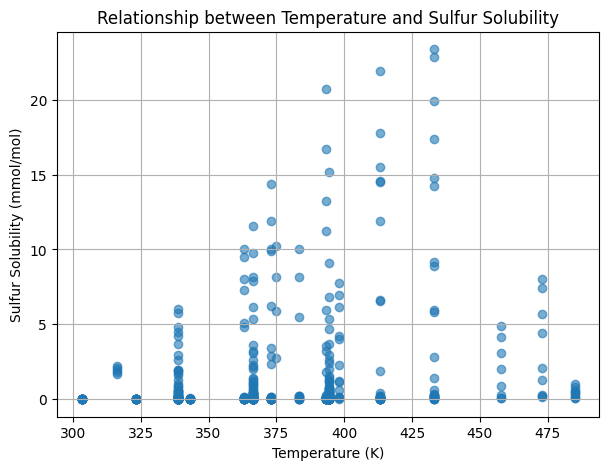

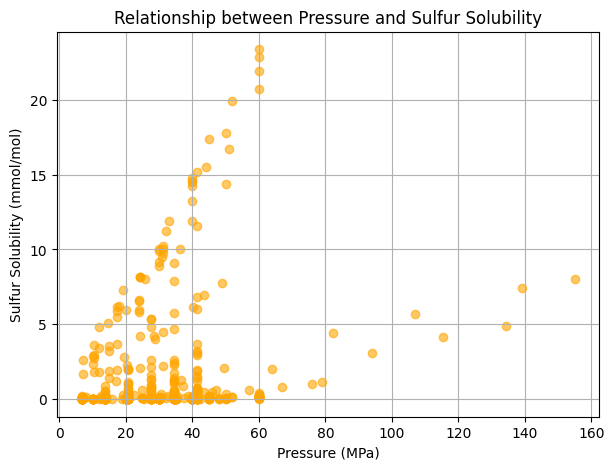

Too many categories in Gas Composition, consider grouping or encoding before plotting.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取最终清洗后的数据
df = pd.read_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data_final.xlsx')

# Temperature vs Sulfur Solubility
plt.figure(figsize=(7,5))
plt.scatter(df['温度（K）'], df['硫溶解度(mmol/mol)'], alpha=0.6)
plt.xlabel('Temperature (K)')
plt.ylabel('Sulfur Solubility (mmol/mol)')
plt.title('Relationship between Temperature and Sulfur Solubility')
plt.grid(True)
plt.show()

# Pressure vs Sulfur Solubility
plt.figure(figsize=(7,5))
plt.scatter(df['压力（MPa）'], df['硫溶解度(mmol/mol)'], alpha=0.6, color='orange')
plt.xlabel('Pressure (MPa)')
plt.ylabel('Sulfur Solubility (mmol/mol)')
plt.title('Relationship between Pressure and Sulfur Solubility')
plt.grid(True)
plt.show()

# Gas Composition vs Sulfur Solubility (boxplot if categories are few)
if df['气体组成'].nunique() < 20:
    plt.figure(figsize=(10,5))
    df.boxplot(column='硫溶解度(mmol/mol)', by='气体组成', grid=False)
    plt.xlabel('Gas Composition')
    plt.ylabel('Sulfur Solubility (mmol/mol)')
    plt.title('Relationship between Gas Composition and Sulfur Solubility')
    plt.suptitle('')
    plt.show()
else:
    print("Too many categories in Gas Composition, consider grouping or encoding before plotting.")

由图像观察可以粗略估计，硫溶解度都随着温度和压力的增大而增大

可以发现，温度图像明显分化出两条直线，可能是不同气体相态导致的

接下来，需要控制气体组成成分的不同，进一步查看精确的关系

首先，统计出气体组成成分总共存在哪些类别

In [19]:
import pandas as pd

# 读取最终清洗后的数据
df = pd.read_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data_final.xlsx')

# 统计气体组成成分的所有唯一类别及其出现次数
composition_counts = df['气体组成'].value_counts()

print("All unique gas composition categories and their counts:")
print(composition_counts)

# 如果需要也可以只看有哪些类别
unique_compositions = df['气体组成'].unique()
print("\nUnique gas composition categories:")
print(unique_compositions)

All unique gas composition categories and their counts:
气体组成
100%H2S                          82
100%CO2                          30
81%CH4+6%H2S+9%CO2+4%N2          28
65%CH4+7%H2S+20%CO2+8%N2         24
81%CH4+1%H2S+14%CO2+4%N2         22
100%CH4                          22
66%CH4+20%H2S+10%CO2+4%N2        19
46.2%CH4+53.8%H2S                18
30.9%H2S+50.0%CO2+19.1%CH4       18
19%CH4+81%H2S                    18
20.3%CH4+79.7%CO2                18
76.7%CH4+23.3%CO2                18
56.80%H2S+22.3%CO2+20.9%CH4      18
53.1%CH4+46.9%CO2                18
32.3%H2S+27.5%CO2+40.2%CH4       18
26.4%H2S+73.6%CO2                18
50.1%H2S+49.9%CO2                18
73.3%H2S+26.7%CO2                18
75.5%CH4+24.5%H2S                18
57%CH4+35%H2S+8%CO2              11
7%CH4+84%H2S+9%CO2               10
56%CH4+42%H2S+2%CO2               9
86%CH4+9%H2S+5%CO2                9
75.48%CH4+17.71%H2S+6.81%CO2      9
87.65%CH4+4.95%H2S+7.4%CO2        8
82.91%CH4+9.93%H2S+7.16%CO2       8
77.

In [10]:
# 100%H2S                          82

# 100%CO2                          30

# 100%CH4                          22

# 20.3%CH4+79.7%CO2                18
# 76.7%CH4+23.3%CO2                18
# 53.1%CH4+46.9%CO2                18

# 26.4%H2S+73.6%CO2                18
# 50.1%H2S+49.9%CO2                18
# 73.3%H2S+26.7%CO2                18

# 46.2%CH4+53.8%H2S                18
# 19%CH4+81%H2S                    18
# 75.5%CH4+24.5%H2S                18

# 30.9%H2S+50.0%CO2+19.1%CH4       18
# 56.80%H2S+22.3%CO2+20.9%CH4      18
# 32.3%H2S+27.5%CO2+40.2%CH4       18
# 57%CH4+35%H2S+8%CO2              11
# 7%CH4+84%H2S+9%CO2               10
# 56%CH4+42%H2S+2%CO2               9
# 86%CH4+9%H2S+5%CO2                9

# 81%CH4+6%H2S+9%CO2+4%N2          28
# 65%CH4+7%H2S+20%CO2+8%N2         24
# 81%CH4+1%H2S+14%CO2+4%N2         22
# 66%CH4+20%H2S+10%CO2+4%N2        19

# 对气体组成成分分类，如上

将相同组成成分合并

In [13]:
import pandas as pd
import re

# 读取最终清洗后的数据
df = pd.read_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data_final.xlsx')

# 只保留气体名（去掉百分比），并按字母排序后合并为标签
def extract_gas_types(comp_str):
    # 匹配所有大写字母开头的气体名（如CH4、CO2、H2S、N2等），忽略前面的百分比
    gases = re.findall(r'[A-Z][A-Z0-9]*', comp_str)
    gases = sorted(set(gases))
    return '+'.join(gases)

df['气体种类标签'] = df['气体组成'].apply(extract_gas_types)

# 保存为新excel
df.to_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data_with_gastype.xlsx', index=False)

# 显示前几行检查
print(df[['气体组成', '气体种类标签']].head())

      气体组成 气体种类标签
0  100%CH4    CH4
1  100%CH4    CH4
2  100%CH4    CH4
3  100%CH4    CH4
4  100%CH4    CH4


统计不同气体组成类别数

In [9]:
import pandas as pd

# 读取最终清洗后的数据（已包含气体种类标签）
df = pd.read_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data_with_gastype.xlsx')

# 统计不同气体种类标签的类别数和每类数量
type_counts = df['气体种类标签'].value_counts()

print("不同气体种类标签及其数量：")
print(type_counts)
print(f"\n气体种类标签总数：{df['气体种类标签'].nunique()}")

不同气体种类标签及其数量：
气体种类标签
CH4+CO2+H2S       150
CH4+CO2+H2S+N2     93
H2S                82
CH4+CO2            54
CH4+H2S            54
CO2+H2S            54
CO2                30
CH4                22
Name: count, dtype: int64

气体种类标签总数：8


由于不同气体组成成分可能会产生不同的反应进而导致硫溶解度不同，接下来分别对每个气体组成成分绘制硫溶解度随温度/压力变化的二维散点图

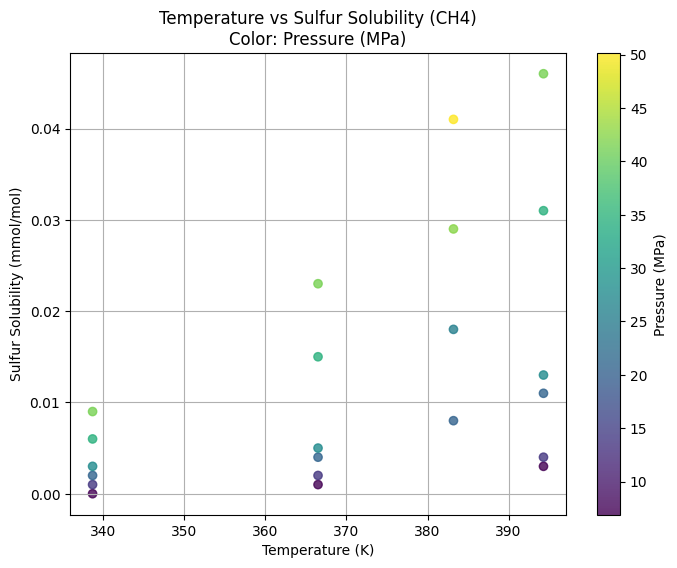

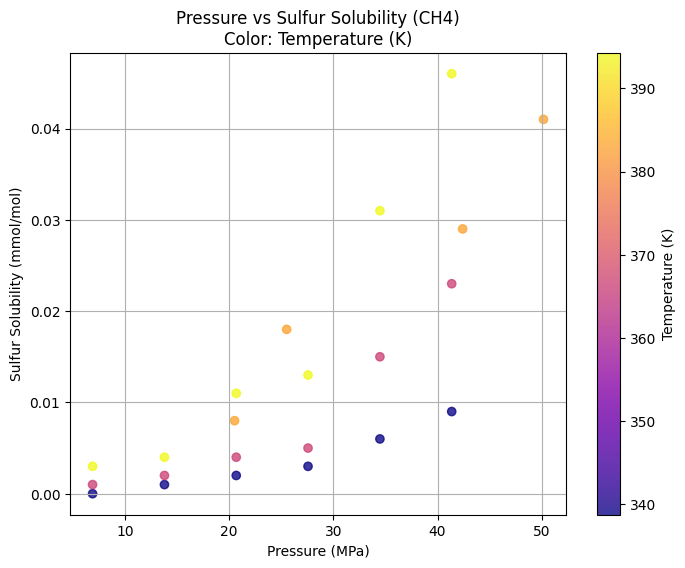

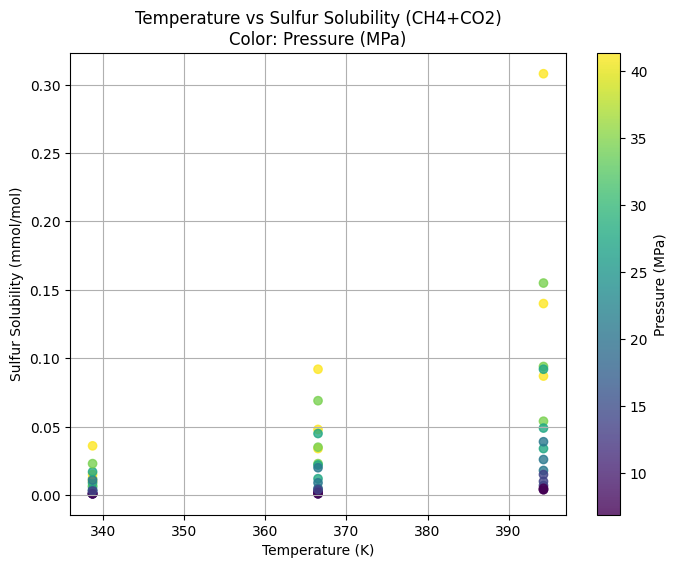

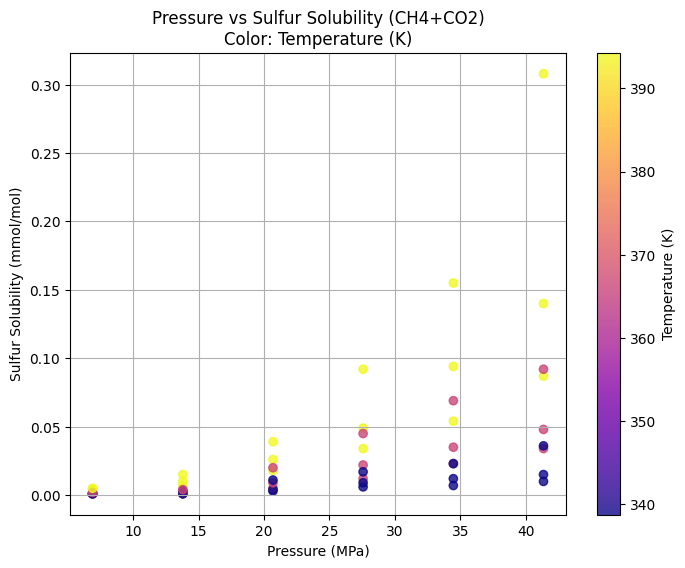

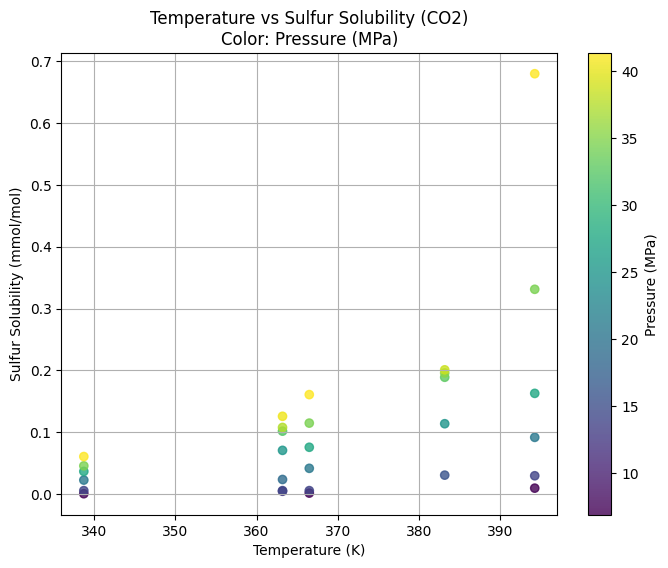

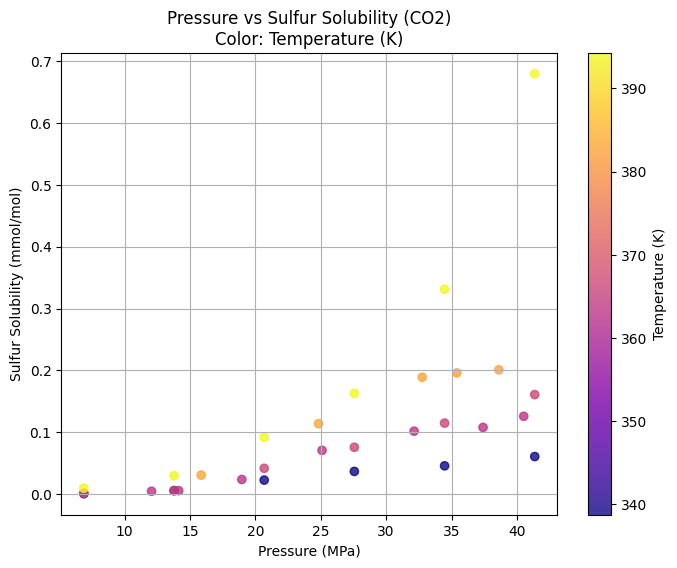

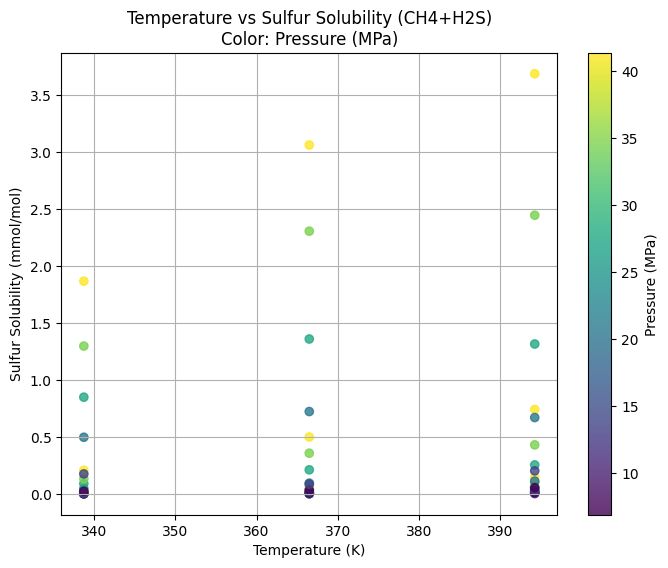

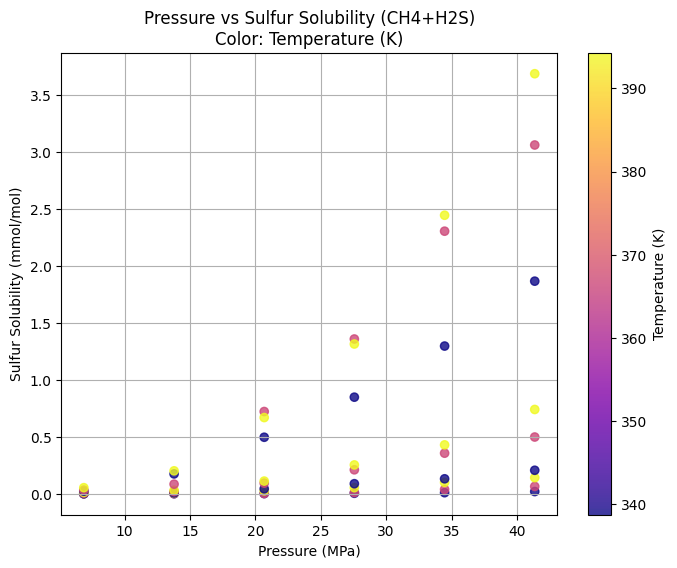

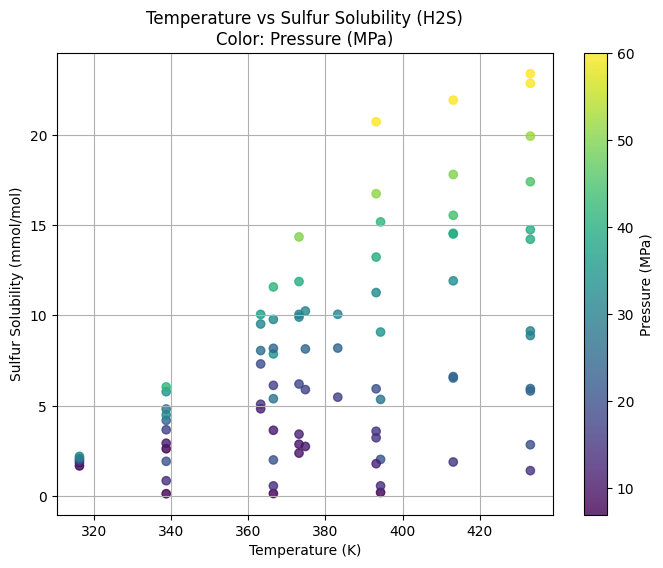

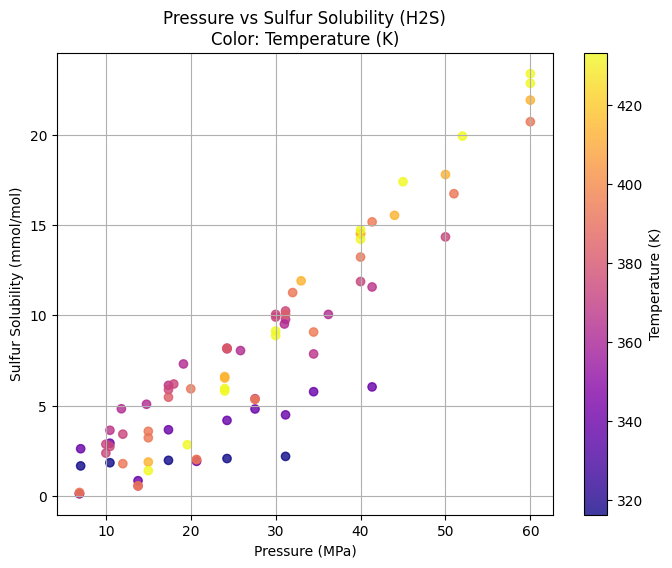

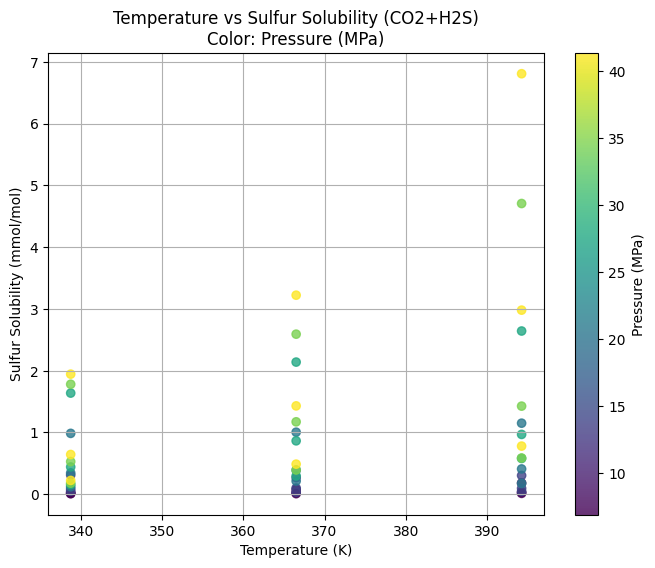

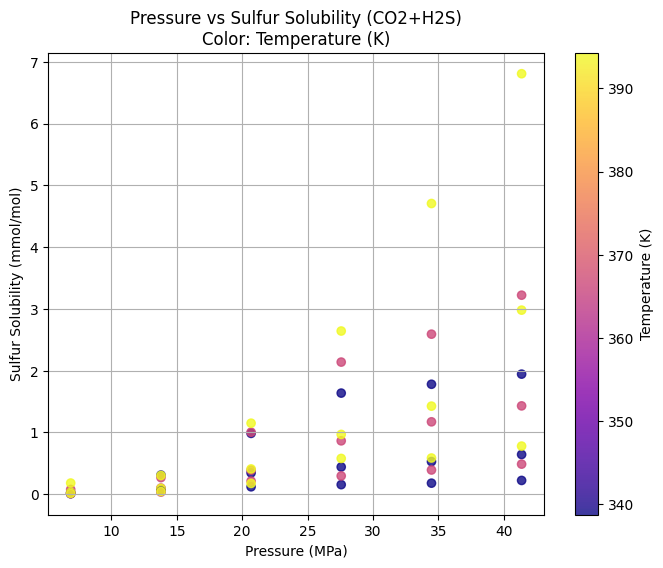

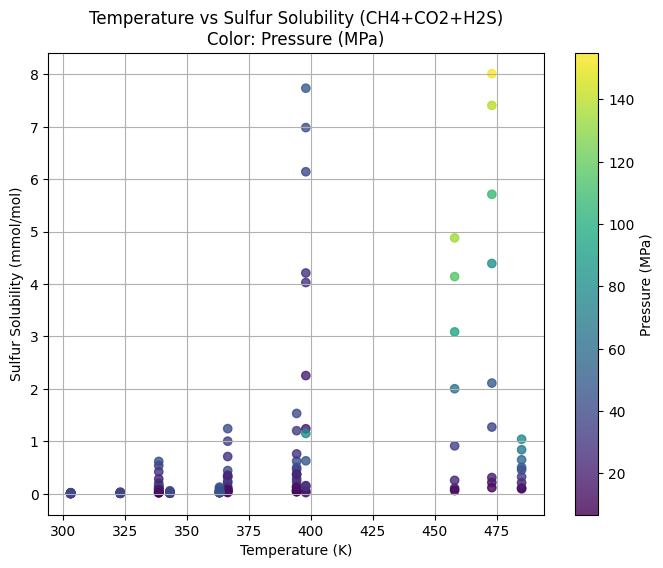

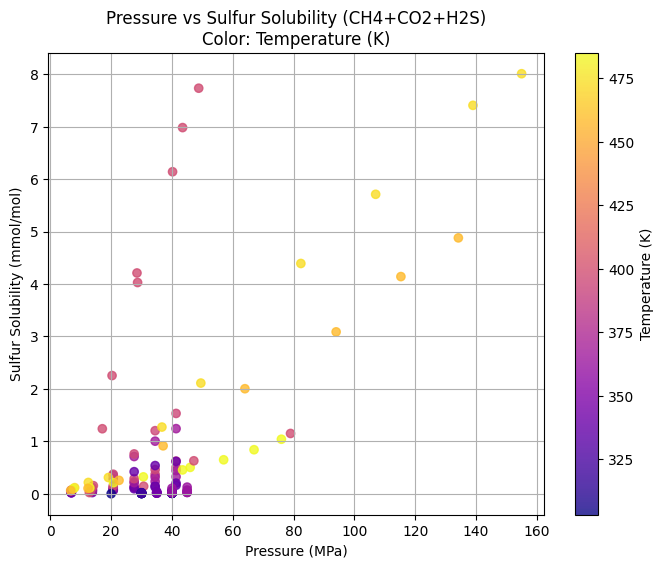

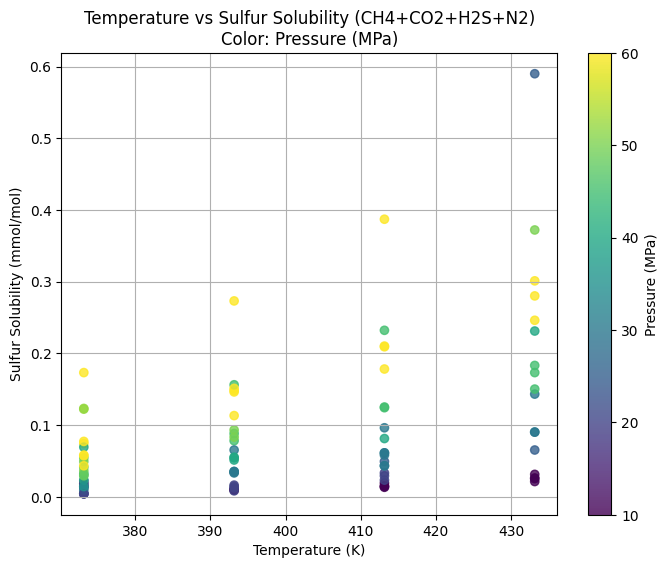

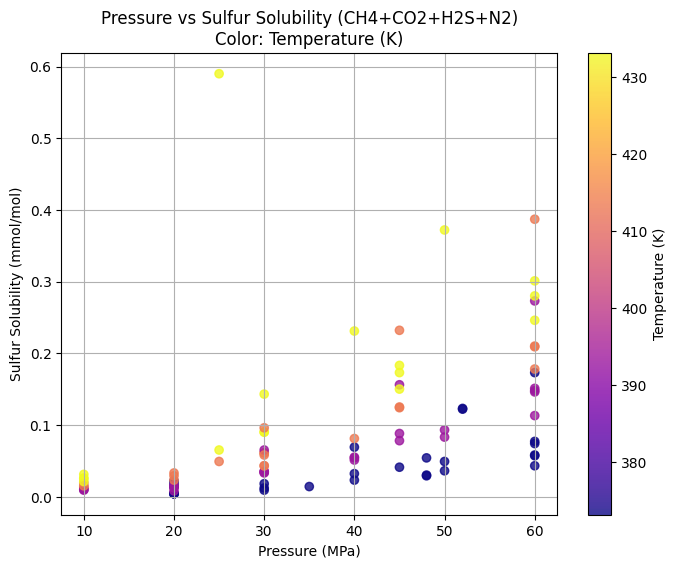

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取已带有“气体种类标签”的数据
df = pd.read_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data_with_gastype.xlsx')

# 获取所有气体种类标签
gas_type_labels = df['气体种类标签'].unique()

for gas_label in gas_type_labels:
    sub_df = df[df['气体种类标签'] == gas_label]
    if len(sub_df) < 5:
        continue  # 跳过样本太少的类别

    # 温度 vs 硫溶解度，点颜色表示压力
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(
        sub_df['温度（K）'],
        sub_df['硫溶解度(mmol/mol)'],
        c=sub_df['压力（MPa）'],
        cmap='viridis',
        alpha=0.8
    )
    plt.xlabel('Temperature (K)')
    plt.ylabel('Sulfur Solubility (mmol/mol)')
    plt.title(f'Temperature vs Sulfur Solubility ({gas_label})\nColor: Pressure (MPa)')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Pressure (MPa)')
    plt.grid(True)
    plt.show()

    # 压力 vs 硫溶解度，点颜色表示温度
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(
        sub_df['压力（MPa）'],
        sub_df['硫溶解度(mmol/mol)'],
        c=sub_df['温度（K）'],
        cmap='plasma',
        alpha=0.8
    )
    plt.xlabel('Pressure (MPa)')
    plt.ylabel('Sulfur Solubility (mmol/mol)')
    plt.title(f'Pressure vs Sulfur Solubility ({gas_label})\nColor: Temperature (K)')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Temperature (K)')
    plt.grid(True)
    plt.show()

①气体压力分析

观察硫溶解度随着气体压力的变化，可以很明显的发现，在大部分情况下，在相同温度下，硫溶解度首先随着气体压力呈指数递增（可以尝试logistics回归或指数回归）

②温度分析

观察硫溶解度随着温度的变化，可以发现，在大部分情况下，在相同气体压力下，硫溶解度首先随着温度呈线性递增

③气体组成成分（仍然需要进一步讨论）

可以明显发现可以将气体组成成分分为两类：含H2S，不含H2S

为了验证无H2S时没有其它副反应的发生这一假设，将如下三个气体组成数据组合，共同做出，硫溶解度随温度/压力变化图

CO2                30

CH4                22

CH4+CO2            54

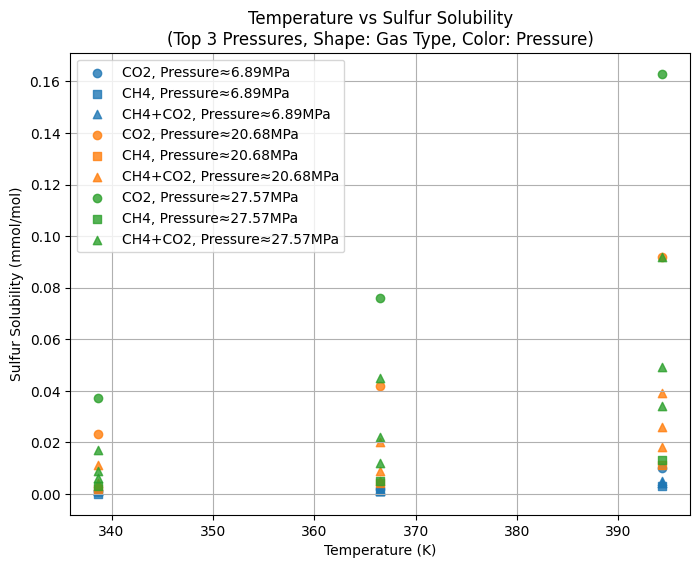

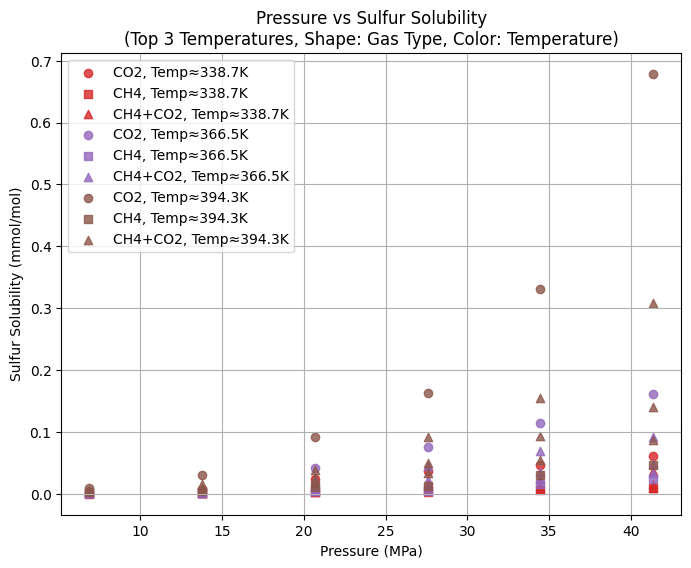

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取已带有“气体种类标签”的数据
df = pd.read_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data_with_gastype.xlsx')

# 只保留CO2、CH4、CH4+CO2三类气体的数据
target_labels = ['CO2', 'CH4', 'CH4+CO2']
sub_df = df[df['气体种类标签'].isin(target_labels)]

# 1. 温度 vs 硫溶解度：只画出现频率最多的3个压力
top_pressures = sub_df['压力（MPa）'].round(2).value_counts().index[:3]
plt.figure(figsize=(8,6))
markers = {'CO2': 'o', 'CH4': 's', 'CH4+CO2': '^'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # 三种压力的颜色
for i, p in enumerate(top_pressures):
    for label in target_labels:
        data = sub_df[(sub_df['气体种类标签'] == label) & (np.isclose(sub_df['压力（MPa）'], p, atol=0.05))]
        if len(data) == 0:
            continue
        plt.scatter(
            data['温度（K）'],
            data['硫溶解度(mmol/mol)'],
            marker=markers[label],
            color=colors[i],
            alpha=0.8,
            label=f'{label}, Pressure≈{p}MPa'
        )
plt.xlabel('Temperature (K)')
plt.ylabel('Sulfur Solubility (mmol/mol)')
plt.title('Temperature vs Sulfur Solubility\n(Top 3 Pressures, Shape: Gas Type, Color: Pressure)')
plt.legend()
plt.grid(True)
plt.show()

# 2. 压力 vs 硫溶解度：只画出现频率最多的3个温度
top_temps = sub_df['温度（K）'].round(1).value_counts().index[:3]
plt.figure(figsize=(8,6))
colors = ['#d62728', '#9467bd', '#8c564b']  # 三种温度的颜色
for i, t in enumerate(top_temps):
    for label in target_labels:
        data = sub_df[(sub_df['气体种类标签'] == label) & (np.isclose(sub_df['温度（K）'], t, atol=0.5))]
        if len(data) == 0:
            continue
        plt.scatter(
            data['压力（MPa）'],
            data['硫溶解度(mmol/mol)'],
            marker=markers[label],
            color=colors[i],
            alpha=0.8,
            label=f'{label}, Temp≈{t}K'
        )
plt.xlabel('Pressure (MPa)')
plt.ylabel('Sulfur Solubility (mmol/mol)')
plt.title('Pressure vs Sulfur Solubility\n(Top 3 Temperatures, Shape: Gas Type, Color: Temperature)')
plt.legend()
plt.grid(True)
plt.show()

从上述可以得出结论，没有H2S参与就没有反应，硫溶解度只与压力和温度有关

接下来，为了进一步研究H2S参与副反应的机理，选取100%H2S的数据，分别控制相同的压力或相同温度下，对另一变量与硫溶解度变化作图，以进一步确定相互关系

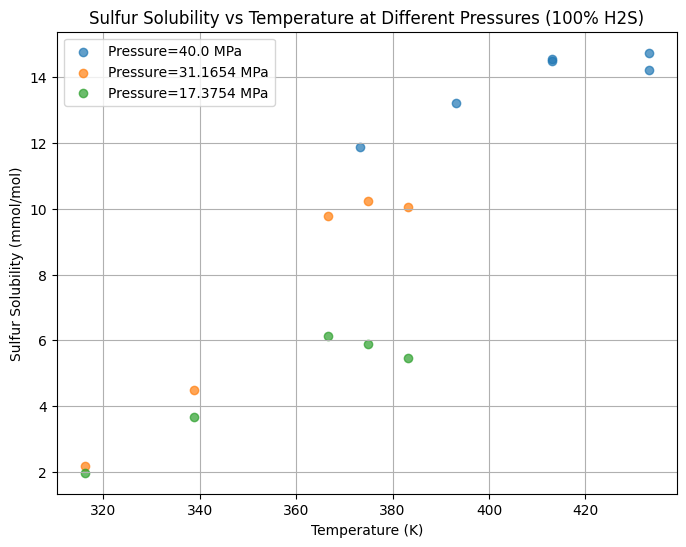

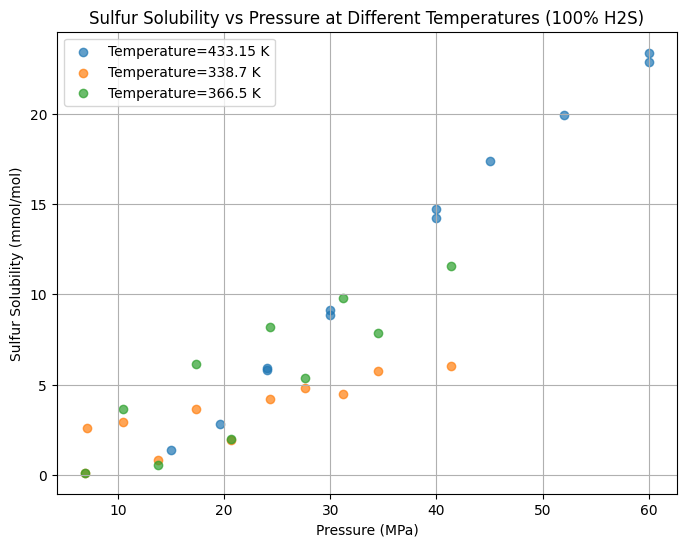

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取最终清洗后的数据
df = pd.read_excel(r'e:\New_Project(python)\数据挖掘\data\cleaned_data_final.xlsx')

# 只保留气体组成为100%H2S的数据
pure_h2s_df = df[df['气体组成'] == '100%H2S']

# 1. 控制压力，观察温度与硫溶解度关系
# 选择出现频率最多的3个压力水平
top_pressures = pure_h2s_df['压力（MPa）'].value_counts().index[:3]
plt.figure(figsize=(8,6))
for p in top_pressures:
    sub = pure_h2s_df[np.isclose(pure_h2s_df['压力（MPa）'], p)]
    if len(sub) > 0:
        plt.scatter(sub['温度（K）'], sub['硫溶解度(mmol/mol)'], label=f'Pressure={p} MPa', alpha=0.7)
plt.xlabel('Temperature (K)')
plt.ylabel('Sulfur Solubility (mmol/mol)')
plt.title('Sulfur Solubility vs Temperature at Different Pressures (100% H2S)')
plt.legend()
plt.grid(True)
plt.show()

# 2. 控制温度，观察压力与硫溶解度关系
# 选择出现频率最多的3个温度水平
top_temps = pure_h2s_df['温度（K）'].value_counts().index[:3]
plt.figure(figsize=(8,6))
for t in top_temps:
    sub = pure_h2s_df[np.isclose(pure_h2s_df['温度（K）'], t)]
    if len(sub) > 0:
        plt.scatter(sub['压力（MPa）'], sub['硫溶解度(mmol/mol)'], label=f'Temperature={t} K', alpha=0.7)
plt.xlabel('Pressure (MPa)')
plt.ylabel('Sulfur Solubility (mmol/mol)')
plt.title('Sulfur Solubility vs Pressure at Different Temperatures (100% H2S)')
plt.legend()
plt.grid(True)
plt.show()

可以发现，有H2S参与反应后，硫溶解度与压力仍然可以近似为线性关系，但是硫溶解度与温度的关系明显有了上限阈值，整体呈现先上升，后下降的趋势

这里大胆假设，